# Behavioral Data Analysis

This notebook generates timecourse analyses and figures for experiments 1 and 2.

# Imports

In [1]:
import pandas as pd; import seaborn as sb; import warnings; import scipy; import re; 
import os; from analysis_helpers import *; import itertools; from scipy import stats
import random; import pandas as pd; import numpy as np; from sklearn import datasets, linear_model; 
from sklearn.linear_model import LinearRegression; import statsmodels.api as sm
from scipy import stats; from itertools import groupby; from operator import itemgetter
warnings.filterwarnings('ignore')
%matplotlib inline

# Load Data

In [2]:
exp1 = pd.DataFrame.from_csv('../parsed_data/behavioral_data_sustained.csv')
exp2 = pd.DataFrame.from_csv('../parsed_data/behavioral_data_variable.csv')

# Data Organize

In [3]:
# Make sure all images labeled by their inherent category (use image filename)
for exp in [exp1, exp2]:
    exp.ix[ exp['Memory Image'].str.contains("sun", na=False),'Category']='Place'
    exp.ix[~exp['Memory Image'].str.contains("sun", na=False),'Category']='Face'
    exp.loc[exp['Trial Type']=='Presentation','Category']=np.nan

    # Number all presentation and memory trials 
    exp.loc[exp['Trial Type']=='Memory','Trial'] = list(range(0,40))*30*8
    exp.loc[exp['Trial Type']=='Presentation','Trial'] = list(range(0,10))*30*8

### Exp1: add cued category from previous presentation to memory trials 

In [4]:
for s in exp1['Subject'].unique():
    for r in exp1['Run'].unique():
        exp1.loc[(exp1['Run']==r) 
                 & (exp1['Subject']==s) 
                 & (exp1['Trial Type']=='Memory'), 'Cued Category'] = exp1.loc[(exp1['Run']==r) & (exp1['Subject']==s) & (exp1['Trial Type']=='Presentation') & (exp1['Trial']==0)]['Cued Category'].item()

### Exp2: add last-cued category from previous presentation to memory trials

In [5]:
exp2['Last Cued'] = np.nan

for sub in exp2['Subject'].unique():
    for run in exp2['Run'].unique():
        
        # obtain cued category from the last presentation trial
        last_cat = exp2[(exp2['Trial Type']=='Presentation')
                       & (exp2['Subject']==sub)
                       & (exp2['Run']==run)
                       & (exp2['Trial']==9)]['Cued Category'].item()
        
        # assign to this memory run
        exp2.loc[(exp2['Trial Type']=='Memory')
                       & (exp2['Subject']==sub)
                       & (exp2['Run']==run),'Last Cued'] = last_cat

### Re-Label Novel images by Cued or Uncued category

In [6]:
exp1 = add_nov_label(exp1, column_name = 'Cued Category')
exp2 = add_nov_label(exp2, column_name ='Last Cued')

### Working version of the data with all Novel images together (not split by cued or uncued)

In [7]:
exp2_Novel = exp2.replace(to_replace=['Nov_Cued','Nov_Un'], value='Novel')
exp1_Novel = exp1.replace(to_replace=['Nov_Cued','Nov_Un'], value='Novel')

In [8]:
# Note : subject 28 in exp 2 has all presentation blocks ending with 'Place' cue !
# exp2[(exp2['Subject']==28) & (exp2['Trial Type']=='Presentation') & (exp2['Trial']==9)]['Cued Category']

# Stats

Below are all of the statistical tests done on the behavioral data, roughly in the order they appear in the paper

### Reaction Time Stats (Cued vs. Uncued side)

In [12]:
# Experiment 1
exp1_gr = exp1.groupby(['Subject','Cue Validity'], as_index=False).mean()

print(scipy.stats.ttest_rel(exp1_gr[exp1_gr['Cue Validity']==1]['Attention Reaction Time (s)'], 
                            exp1_gr[exp1_gr['Cue Validity']==0]['Attention Reaction Time (s)']))

print(cohen_d(list(exp1_gr[exp1_gr['Cue Validity']==1]['Attention Reaction Time (s)']),list(exp1_gr[exp1_gr['Cue Validity']==0]['Attention Reaction Time (s)'])))

Ttest_relResult(statistic=-2.726564495656624, pvalue=0.010744006694709042)
-0.3675655964093691


In [14]:
# Experiment 2
exp2_gr = exp2.groupby(['Subject','Cue Validity'], as_index=False).mean()

print(scipy.stats.ttest_rel(exp2_gr[exp2_gr['Cue Validity']==1]['Attention Reaction Time (s)'], 
                            exp2_gr[exp2_gr['Cue Validity']==0]['Attention Reaction Time (s)']))

print(cohen_d(list(exp2_gr[exp2_gr['Cue Validity']==1]['Attention Reaction Time (s)']),
              list(exp2_gr[exp2_gr['Cue Validity']==0]['Attention Reaction Time (s)'])))

Ttest_relResult(statistic=0.015703450175793242, pvalue=0.9875785155263901)
0.002398007255732831


### Reaction Time Differences

In [15]:
diffs = {'Experiment_1':[], 'Experiment_2':[]}

for d,label in zip([exp1, exp2],['Experiment_1', 'Experiment_2']):
    
    for s in d['Subject'].unique():
        cued   = d[(d['Subject']==s)&(d['Cue Validity']==0)]['Attention Reaction Time (s)'].mean()
        uncued = d[(d['Subject']==s)&(d['Cue Validity']==1)]['Attention Reaction Time (s)'].mean()

        diffs[label].append(cued - uncued)

print('RT Diff Comparison')
print(scipy.stats.ttest_ind(diffs['Experiment_1'], diffs['Experiment_2']))
print(cohen_d(diffs['Experiment_1'], diffs['Experiment_2']))

RT Diff Comparison
Ttest_indResult(statistic=1.8165038608218964, pvalue=0.07446168516704983)
0.46901928008564536


### Compare Fully Attended images to all other images

In [16]:
for d,label in zip([exp1, exp2],['Experiment_1', 'Experiment_2']):
    Fulls  = []
    Others = []
    
    for s in d['Subject'].unique():
        
        Fulls.append(d[(d['Subject']==s)&(d['Attention Level']=='Full')]['Familiarity Rating'].mean())
        Others.append(d[(d['Subject']==s) &(d['Attention Level']!='Full')]['Familiarity Rating'].mean())
        
    print(label)
    print(scipy.stats.ttest_rel(Fulls, Others))
    print(cohen_d(Fulls, Others))
    print()

Experiment_1
Ttest_relResult(statistic=9.396112809093742, pvalue=2.6596964490466333e-10)
1.518595693210898

Experiment_2
Ttest_relResult(statistic=5.567191437174967, pvalue=5.252532785886715e-06)
0.6962485278902368



### Face versus Scene

In [18]:
for exp,label in zip([exp1, exp2],['Experiment_1', 'Experiment_2']):
    f_p = exp.groupby(['Category', 'Subject', 'Attention Level'], as_index=False).mean()
    print(label)
    print(scipy.stats.ttest_rel(f_p[(f_p['Category']=='Place') & (f_p['Attention Level']=='Full')]['Familiarity Rating'], 
                                f_p[(f_p['Category']=='Face') & (f_p['Attention Level']=='Full')]['Familiarity Rating']))
    print(cohen_d(f_p[(f_p['Category']=='Place') & (f_p['Attention Level']=='Full')]['Familiarity Rating'], 
                                f_p[(f_p['Category']=='Face') & (f_p['Attention Level']=='Full')]['Familiarity Rating']))
    print()
          

Experiment_1
Ttest_relResult(statistic=5.5990321530636935, pvalue=4.809466356149415e-06)
0.9894809544013213

Experiment_2
Ttest_relResult(statistic=3.6122493003149714, pvalue=0.001133445225594122)
0.8213105625370904



### Attended Category versus Unattended

In [20]:
for d,label in zip([exp1_Novel, exp2_Novel],['Experiment_1', 'Experiment_2']):
    Cats  = []
    Nones = []
    
    for s in d['Subject'].unique():
        
        Cats.append(d[(d['Subject']==s) & (d['Attention Level'].isin(['Category']))]['Familiarity Rating'].mean())
        Nones.append(d[(d['Subject']==s) & (d['Attention Level']=='None')]['Familiarity Rating'].mean())

    print(label)
    print(scipy.stats.ttest_rel(Cats, Nones))
    print(cohen_d(Cats, Nones))
    print()

Experiment_1
Ttest_relResult(statistic=5.1684995922238475, pvalue=1.5879652460430842e-05)
0.6987928234589805

Experiment_2
Ttest_relResult(statistic=-0.013365259637578319, pvalue=0.9894279086029338)
-0.001184274640031099



### Attended Side vs Unattended

In [21]:
for d,label in zip([exp1_Novel, exp2_Novel],['Experiment_1', 'Experiment_2']):
    Sides  = []
    Nones = []
    
    for s in d['Subject'].unique():
        
        Sides.append(d[(d['Subject']==s) & (d['Attention Level'].isin(['Side']))]['Familiarity Rating'].mean())
        Nones.append(d[(d['Subject']==s) & (d['Attention Level']=='None')]['Familiarity Rating'].mean())

    print(label)
    print(scipy.stats.ttest_rel(Sides, Nones))
    print(cohen_d(Sides, Nones))
    print()

Experiment_1
Ttest_relResult(statistic=3.7879181404481477, pvalue=0.0007093128554569094)
0.3098706279896764

Experiment_2
Ttest_relResult(statistic=3.571140095865606, pvalue=0.0012637760904546636)
0.6344078084137651



### Cued versus Uncued Novel images

In [22]:
for d,label in zip([exp1, exp2],['Experiment_1','Experiment_2']):
    
    d = d.groupby(['Subject','Attention Level'], as_index=False).mean()
    
    print(label)
    
    a = d[d['Attention Level']=='Nov_Cued']['Familiarity Rating']
    b = d[d['Attention Level']=='Nov_Un']['Familiarity Rating']
    
    print(scipy.stats.ttest_rel(a, b))
    print(cohen_d(a, b))
    print()
    

Experiment_1
Ttest_relResult(statistic=5.644488500528174, pvalue=4.241252223029619e-06)
0.7322031592565833

Experiment_2
Ttest_relResult(statistic=0.22263341929217778, pvalue=0.8253814425522065)
0.027818540448205635



### Feature boost versus feature bias boost

In [23]:
diffs = {'Experiment_1':[], 'Experiment_2':[]}

for d,label in zip([exp1, exp2],['Experiment_1', 'Experiment_2']):
    cat_no = []
    nov_diff = []
    
    for s in d['Subject'].unique():
        cat = d[(d['Subject']==s)&(d['Attention Level'].isin(['Category', 'Full']))]['Familiarity Rating'].mean()
        no = d[(d['Subject']==s) &(d['Attention Level']=='None')]['Familiarity Rating'].mean()
        nov_c = d[(d['Subject']==s) &(d['Attention Level']=='Nov_Cued')]['Familiarity Rating'].mean()
        nov_u = d[(d['Subject']==s) &(d['Attention Level']=='Nov_Un')]['Familiarity Rating'].mean()
        
        cat_no.append(cat - no)
        nov_diff.append(nov_c - nov_u)
        
        
    print(label)
    print(scipy.stats.ttest_rel(cat_no, nov_diff))
    print(cohen_d(cat_no, nov_diff))
    print()


Experiment_1
Ttest_relResult(statistic=4.908617050185994, pvalue=3.2701039322672875e-05)
0.7373961684964727

Experiment_2
Ttest_relResult(statistic=1.6510196976743885, pvalue=0.10952446838103283)
0.4014610220443808



### Feature boost versus Location boost

In [17]:
# Exp 1: mean(Cat & Full) - mean(None)
# versus
# Exp 1: mean(Side & Full) - mean(None)

# Exp 2: mean(Cat & Full) - mean(None)
# versus
# Exp 2: mean(Side & Full) - mean(None)


# Experiment 1: ( (mean(Cat & Full) - mean(None))  -    (mean(Side & Full) - mean(None)) )    
# versus
# Experiment 2: ( (mean(Cat & Full) - mean(None))   -    (mean(Side & Full) - mean(None)) )    

In [25]:
diffs = {'Experiment_1':[], 'Experiment_2':[]}
side_diffs = {'Experiment_1':[], 'Experiment_2':[]}

for d,label in zip([exp1_Novel, exp2_Novel],['Experiment_1', 'Experiment_2']):
    cat_nov = []
    side_nov = []
    
    for s in d['Subject'].unique():
        side = d[(d['Subject']==s)&(d['Attention Level'].isin(['Side','Full']))]['Familiarity Rating'].mean()
        cat = d[(d['Subject']==s)&(d['Attention Level'].isin(['Category', 'Full']))]['Familiarity Rating'].mean()
        nov = d[(d['Subject']==s) &(d['Attention Level']=='None')]['Familiarity Rating'].mean()
        
        cat_nov.append(cat - nov)
        side_nov.append(side - nov)
        
        
    print(label)
    print(scipy.stats.ttest_rel(cat_nov, side_nov))
    print(cohen_d(cat_nov, side_nov))
    print()
    
    side_diffs[label] = side_nov
    diff = [x-y for x,y in zip(cat_nov,side_nov)]
    diffs[label] = diff
    
print()
print('Feature boost relative to Location boost, Exp1 vs Exp 2')
print(scipy.stats.ttest_ind(diffs['Experiment_1'], diffs['Experiment_2']))
print(cohen_d(diffs['Experiment_1'], diffs['Experiment_2']))
print()
print('Location boost relative to novel, Exp2 vs Exp1')
print(scipy.stats.ttest_ind(side_diffs['Experiment_2'], side_diffs['Experiment_1']))
print(cohen_d(side_diffs['Experiment_2'], side_diffs['Experiment_1']))

Experiment_1
Ttest_relResult(statistic=2.0408065546020406, pvalue=0.0504655227194427)
0.24144943818485862

Experiment_2
Ttest_relResult(statistic=-3.659203543584972, pvalue=0.0010005362417606367)
-0.4105589495659398


Feature boost relative to Location boost, Exp1 vs Exp 2
Ttest_indResult(statistic=3.9456393034115114, pvalue=0.00021738230280496541)
1.0187596874836145

Location boost relative to novel, Exp2 vs Exp1
Ttest_indResult(statistic=-2.741131205178287, pvalue=0.008126392249491046)
-0.7077570338283313


### Fully Attended versus Side Attended boost

In [27]:
diffs = {'Experiment_1':[], 'Experiment_2':[]}
side_diffs = {'Experiment_1':[], 'Experiment_2':[]}

for d,label in zip([exp1_Novel, exp2_Novel],['Experiment_1', 'Experiment_2']):
    cat_nov = []
    side_nov = []
    
    for s in d['Subject'].unique():
        side = d[(d['Subject']==s)&(d['Attention Level'].isin(['Side']))]['Familiarity Rating'].mean()
        cat = d[(d['Subject']==s)&(d['Attention Level'].isin(['Full']))]['Familiarity Rating'].mean()
        nov = d[(d['Subject']==s) &(d['Attention Level']=='None')]['Familiarity Rating'].mean()
        
        cat_nov.append(cat - nov)
        side_nov.append(side - nov)
        
        
    print(label)
    print(scipy.stats.ttest_rel(cat_nov, side_nov))
    print(cohen_d(cat_nov, side_nov))
    print()
    
    side_diffs[label] = side_nov
    diff = [x-y for x,y in zip(cat_nov,side_nov)]
    diffs[label] = diff
    
print()
print('Feature boost relative to Location boost, Exp1 vs Exp 2')
print(scipy.stats.ttest_ind(diffs['Experiment_1'], diffs['Experiment_2']))
print(cohen_d(diffs['Experiment_1'], diffs['Experiment_2']))
print()
print('Location boost relative to novel, Exp2 vs Exp1')
print(scipy.stats.ttest_ind(side_diffs['Experiment_2'], side_diffs['Experiment_1']))
print(cohen_d(side_diffs['Experiment_2'], side_diffs['Experiment_1']))

Experiment_1
Ttest_relResult(statistic=6.614537828573972, pvalue=2.996178170829052e-07)
1.5817539345746288

Experiment_2
Ttest_relResult(statistic=-0.5288524866649059, pvalue=0.600932520939712)
-0.07901120477832496


Feature boost relative to Location boost, Exp1 vs Exp 2
Ttest_indResult(statistic=5.869694853976254, pvalue=2.2330866774852655e-07)
1.5155486944512946

Location boost relative to novel, Exp2 vs Exp1
Ttest_indResult(statistic=1.0293665534009377, pvalue=0.30758111967713664)
0.2657813012309842


# Plot Data

## Violin Plots 

Experiment_1: Average Familiarity by Attention Level


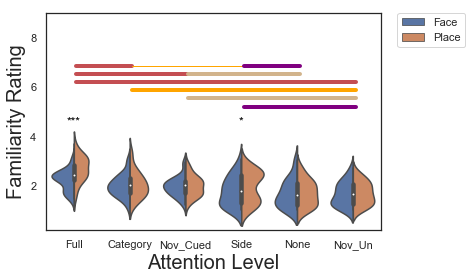

Experiment_2: Average Familiarity by Attention Level


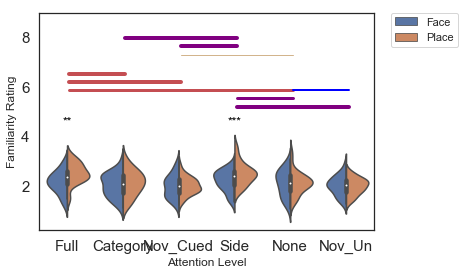

In [20]:
stat_dict_full = {'Experiment_1':{}, 'Experiment_2':{}}

# color list 
col = ['r','orange','tan','purple','blue','grey']
col_neg = ['grey','blue', 'purple', 'tan', 'orange', 'r']

# cat list
cats = ['Full','Category','Nov_Cued','Side','None','Nov_Un']

# plot settings
sb.set_style("white")
plt.grid(False)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.xlabel('Attention Level',    fontsize = 20)
plt.ylabel('Familiarity Rating', fontsize = 20)

# for each experiment, group and plot
for d,label in zip([exp1, exp2],['Experiment_1', 'Experiment_2']):
    
    data = d.groupby(['Subject','Attention Level', 'Category'], as_index = False).mean()
    
    print(label + ': Average Familiarity by Attention Level')
    
    sb_plot = sb.violinplot(x='Attention Level', y='Familiarity Rating', 
                 data = data, hue='Category', split=True,
                 order=cats)
    sb_plot.set(ylim=(.2, 9))
    ax1 = sb_plot.axes
    
    
    ### WITHIN VIOLIN SIGNIFICANCE FOR PLOTTING ###
    t_draw = {}
    
    for c in data['Attention Level'].unique():
        
        if c in(['Nov_Cued','Nov_Un']) and label=='Experiment_2':
        
            # if comparing novel images from exp2, eliminate participant 28 (all Place-cued as last cued category)
            first  = list(data[(data['Attention Level']==c) & (data['Category']=='Face') & (data['Subject']!=28)]['Familiarity Rating'])
            second = list(data[(data['Attention Level']==c) & (data['Category']=='Place') & (data['Subject']!=28)]['Familiarity Rating'])

        else:
            first  = list(data[(data['Attention Level']==c) & (data['Category']=='Face')]['Familiarity Rating'])
            second = list(data[(data['Attention Level']==c) & (data['Category']=='Place')]['Familiarity Rating'])
            
        t = scipy.stats.ttest_rel(first, second)

        if t[1]<.001:
            t_draw[c] = '***'
            
        elif t[1]<.01:
            t_draw[c] = '**'
        
        elif t[1]<.05:
            t_draw[c] = '*'
            
        elif t[1]<.056:
            t_draw[c] = '+'
    
    ### SIGNIFICANCE FOR PLOTTING ###
    stat_dict = {}
    k = data.groupby(['Subject','Attention Level'],as_index=False).mean()

    for pair in list(itertools.combinations(cats, r=2)):
        t = stats.ttest_rel(k[k['Attention Level']==pair[0]]['Familiarity Rating'], 
                            k[k['Attention Level']==pair[1]]['Familiarity Rating'])
        stat_dict_full[label][pair] = {'t': t.statistic, 'p': t.pvalue}

        # dictionary where every key is a pair of sig dif categories 
        if t[1]<.056:
            stat_dict[pair] = {'t': t.statistic, 'p': t.pvalue}
        
    ### ADD SIG BARS FOR POSITIVE RELATIONSHIPS TO PLOT ###
    plotted_cats = []
    to_be_plotted = []
    
    line_counter = 0
    
    for idx,c in enumerate(cats):
    # for each category
    
        x = sig_bars(c, cats, stat_dict)
        # get first series of lines
        
        for idx,a in enumerate(x):
            
            if (a['categories'] not in plotted_cats) and (a!=np.nan) and (type(a['categories'])!=float):
                a['y'] = a['y'] + line_counter
                to_be_plotted.append(a)
                plotted_cats.append(a['categories'])

            if a['next']!=0:
            # if next category also has significant relationship
            
                fake_first = a['categories'][0]
                b = a
                
                while b['next']!= 0 :
                    
                    second_fake_first = b['categories'][0]
                    
                    b = sig_bars(b['next'], cats, stat_dict, adjust = (cats.index(c)-cats.index(b['next']))/len(cats))[0]
                    # get params for that bar, adjust height --> same level as first line
                    if (b['categories'] not in plotted_cats) and (b != np.nan) and (type(b['categories'])!=float):
                        b['y'] = b['y'] + line_counter
                        to_be_plotted.append(b)
                            
                        plotted_cats.append(b['categories'])
                        plotted_cats.append((fake_first, b['categories'][1]))
                        plotted_cats.append((second_fake_first, b['categories'][1]))
                        
                        if type(plotted_cats[-1]) != float:
                            l = plotted_cats[-1][0]

                        plotted_cats.append((l,plotted_cats[-1][1]))
                        plotted_cats.append((fake_first,plotted_cats[-1][1]))
           
            line_counter += .3
                        
            if type(plotted_cats[-1]) == str:
                fake_last = plotted_cats[-1][1]
                plotted_cats.append((fake_first, fake_last))
    
    # get the unique y values
    y_vals = [x['y'] for x in to_be_plotted]
    unique = list(set(y_vals))
    unique.sort(reverse=True)

    # move each to desired location
    new_to_be_plotted = []

    for idx,u in enumerate(unique):
        for line in to_be_plotted:
            if line['y']==u:
                line['y'] = (idx/3)+5.2
                new_to_be_plotted.append(line)

    for each in new_to_be_plotted:
        ax1.axhline(each['y'], ls='-', xmin = each['x_min'], xmax = each['x_max'], 
            linewidth = each['width'], color = col[cats.index(each['categories'][0])])

    ### ADD SIG BARS FOR NEGATIVE RELATIONSHIPS TO PLOT ###
    plotted_cats = []
    to_be_plotted = []
    
    line_counter = 0
    
    for idx,c in enumerate(cats):
    # for each category 
    
        x = sig_bars_neg(c, cats, stat_dict)
        # get first series of lines
        
        for idx,a in enumerate(x):
            
            if (a['categories'] not in plotted_cats) and (a!=np.nan) and (type(a['categories'])!=float):
                a['y'] = a['y'] + line_counter
                to_be_plotted.append(a)
                plotted_cats.append(a['categories'])
            
            if a['next']!=0:
            # if next category also has significant relationship
                
                fake_first = a['categories'][0]
                b = a
                
                while b['next']!= 0 :
                    
                    second_fake_first = b['categories'][0]
                    
                    b = sig_bars_neg(b['next'], cats, stat_dict, adjust = (cats.index(c)-cats.index(b['next']))/len(cats))[0]
                    # get params for that bar, adjust height --> same level as first line

                    if (b['categories'] not in plotted_cats) and (b != np.nan) and (type(b['categories'])!=float):
                        
                        b['y'] = b['y'] + line_counter
                        to_be_plotted.append(b)
                        
                        plotted_cats.append(b['categories'])
                        
                        plotted_cats.append((fake_first, b['categories'][1]))
                        plotted_cats.append((second_fake_first, b['categories'][1]))

                        if type(plotted_cats[-1]) != float:
                            l = plotted_cats[-1][0]
                                       
            line_counter += .3
            
                                    
            if len(plotted_cats)>0 and type(plotted_cats[-1]) == str:
                fake_last = plotted_cats[-1][1]
                plotted_cats.append((fake_first, fake_last))
    
    # get the unique y values
    y_vals = [x['y'] for x in to_be_plotted]
    unique = list(set(y_vals))
    unique.sort(reverse=True)

    # move each to desired location
    new_to_be_plotted = []

    for idx,u in enumerate(unique):
        for line in to_be_plotted:
            if line['y']==u:
                line['y'] = (idx/3)+7.3
                new_to_be_plotted.append(line)
                

    for each in new_to_be_plotted:
        ax1.axhline(each['y'], ls='-', xmin = each['x_min'], xmax = each['x_max'], 
            linewidth = each['width'], color = col[-cats.index(each['categories'][1])])
    for stars in t_draw:
        ax1.text((cats.index(stars)), 4.5, t_draw[stars], horizontalalignment='center', size='large', color='black')
        
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

## Timecourse Plots

In [21]:
# Apply sliding window
window_length = 20

exp1_mean_window = apply_window(exp1, window_length)
exp2_mean_window = apply_window(exp2, window_length)

# prepare data for plotting
plot_data={}

for data,key in zip([exp1_mean_window, exp2_mean_window],['exp1','exp2']):
    
    # average across all trials within each subject
    group = data.reset_index().groupby(['Subject','Trial']).mean()
    
    # melt/restructure the data
    group_melt = pd.melt(group.reset_index(), id_vars=['Subject','Trial'], 
                         value_vars=['Category', 'Full','None','Nov_Un', 'Nov_Cued','Side'])
    
    # assign data to dictionary key
    plot_data[key] = group_melt
    
# plotting color key
palette = sb.color_palette("RdBu", 20)
# Cued category    -->  warm colors 
# Uncued category  -->  cool colors

In [22]:
# # Prepare data for plotting
# plot_data={}

# for data,key in zip([exp1_mean_window, exp2_mean_window],['exp1','exp2']):
    
#     # average across all trials within each subject
#     group = data.reset_index().groupby(['Subject','Trial']).mean()
    
#     # melt/restructure the data
#     group_melt = pd.melt(group.reset_index(), id_vars=['Subject','Trial'], 
#                          value_vars=['Category', 'Full','None','Nov_Un', 'Nov_Cued','Side'])
    
#     # assign data to dictionary key
#     plot_data[key] = group_melt
    
# # plotting color key
# palette = sb.color_palette("RdBu", 20)
# Cued category    -->  warm colors 
# Uncued category  -->  cool colors

## Sliding Window - Familiarity Over Time

### Sliding Window - Novel Images

exp1: Sliding Window - Novel Images Only


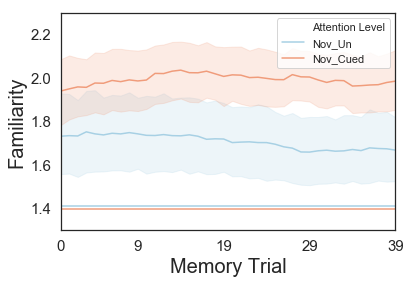

exp2: Sliding Window - Novel Images Only


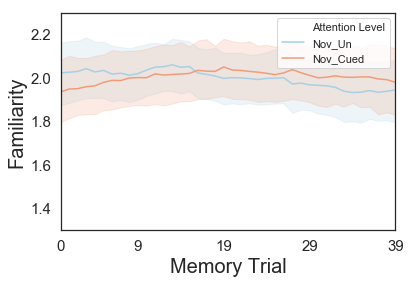

In [23]:
import scipy

sb.set_style("white")

for key,label in zip(plot_data.keys(),['Experiment_1','Experiment_2']):
    
    print(key + ': Sliding Window - Novel Images Only')
    
    data = plot_data[key]
    
    # plot data
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Nov_Un','Nov_Cued'])], # ci=None,
                palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13]})
    ax.set(ylim=(1.3, 2.3))
    ax.set(xlim=(0, 39))
    
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    plt.xlabel('Memory Trial')
    plt.ylabel('Familiarity')
    
    # ttest at each timepoint ######################
    ttest_data = timepoint_ttest(data, ['Nov_Cued','Nov_Un'])
    
    # add lines where pvalue is significant
    index = ttest_data[(ttest_data['Attention Level']=='Nov_Un') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.41, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[13])
            plt.axhline( y=1.4, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[5])
        
        plt.axhline( y=1.41, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[13])
        plt.axhline( y=1.4, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[5])
        # plt.axvline(x, .1, .3, color='red')
    
    plt.xticks([0, 9, 19, 29, 39])
    
    plt.show()    
    

### Novel Image Difference Scores

slope = 0.002606553384591277
intercept = 0.23460738828051547
p_value = 7.438997285666216e-13

exp1


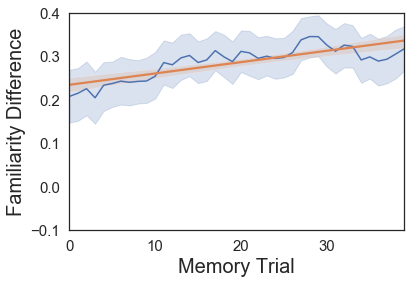

slope = 0.0038157803993496497
intercept = -0.06814893684438543
p_value = 1.1480295011379609e-35

exp2


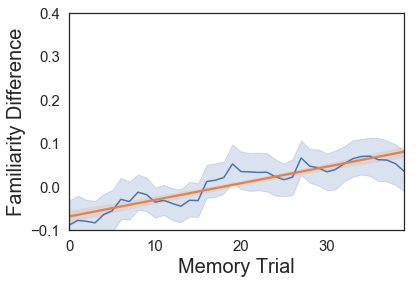

In [24]:
from sklearn.linear_model import LinearRegression

for exp in plot_data.keys():
    
    trial_avs = plot_data[exp].groupby(['Trial','Attention Level','Subject'], as_index=False).mean()
    trial_avs['Nov_Diffs'] = np.nan
    
    for s in trial_avs['Subject'].unique():
        for t in trial_avs['Trial'].unique():

            first  = trial_avs[(trial_avs['Attention Level']=='Nov_Cued') 
                               & (trial_avs['Trial']==t)
                              & (trial_avs['Subject']==s)]['value'].item()
            second = trial_avs[(trial_avs['Attention Level']=='Nov_Un'  ) 
                               & (trial_avs['Trial']==t)
                              & (trial_avs['Subject']==s)]['value'].item()
            difference = first - second

            trial_avs.loc[(trial_avs['Trial']==t) & (trial_avs['Subject']==s),'Nov_Diffs'] = first - second

    ax = sb.lineplot(x='Trial', y='Nov_Diffs', data=trial_avs)
    ax.set(ylim=(-.1, .4))
    ax.set(xlim=(0, 39))
    
    sb.regplot(x="Trial", y="Nov_Diffs", data=trial_avs, scatter=False)
    
    trial_av_grp = trial_avs.groupby(['Trial'], as_index=False).mean()
    slope, intercept, r_value, p_value, std_err = stats.linregress(trial_avs['Trial'], trial_avs['Nov_Diffs'])
    
    print('slope = ' + str(slope))
    print('intercept = ' + str(intercept))
    print('p_value = ' + str(p_value))
    print()
        
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    plt.xlabel('Memory Trial')
    plt.ylabel('Familiarity Difference')
    
    print(exp)
    plt.show()


### Uncued Category images


Experiment 1: Sliding Window - Uncued Category Images


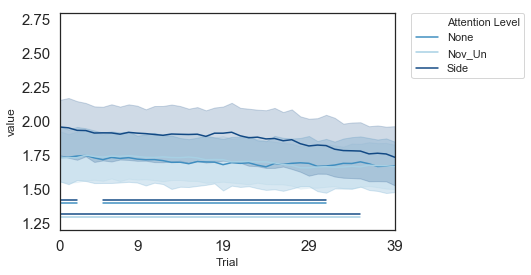

Experiment 2: Sliding Window - Uncued Category Images


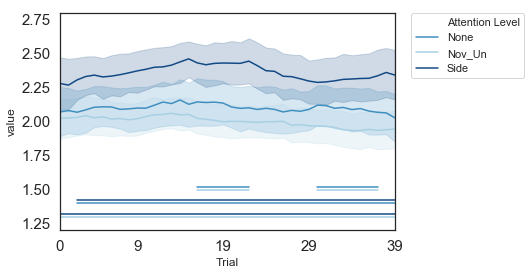

In [25]:
sb.set_style("white")

for key,label in zip(plot_data.keys(),['Experiment 1','Experiment 2']):
    
    print(label + ': Sliding Window - Uncued Category Images')
    
    data = plot_data[key]
    
    # plot data
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Side','None','Nov_Un'])], # ci=None,
                    palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], 'Novel':'black'}) 
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.2, 2.8))
    ax.set(xlim=(0, 39))

    
    # stats test
    data = data[data['Attention Level'].isin(['Side','None','Nov_Un'])]
    
    #ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Side','Nov_Un'])#, related=False)
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Nov_Un') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    
    for x in ranges(index):
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[19])
            plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[13])
                        
        else:
            plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[19])
            plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[13])
        
        
    # ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Side','None'])
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Side') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.42, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[19])
            plt.axhline( y=1.4, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[16])
            
        else:
            plt.axhline( y=1.42, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[19])
            plt.axhline( y=1.4, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[16])
        
    # ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Nov_Un','None'])#, related=False)
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Nov_Un') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.52, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[16])
            plt.axhline( y=1.5, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[13])
    
        else:
            plt.axhline( y=1.52, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[16])
            plt.axhline( y=1.5, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[13])

        
    plt.xticks([0, 9, 19, 29, 39])
    
    plt.show()
    

### Sliding Window - Images in Cued Category

Experiment_1: Sliding Window - Same Category Images - Faces


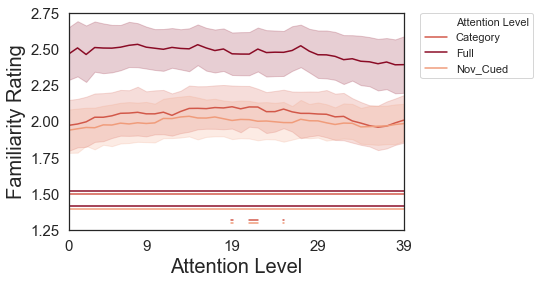

Experiment_2: Sliding Window - Same Category Images - Faces


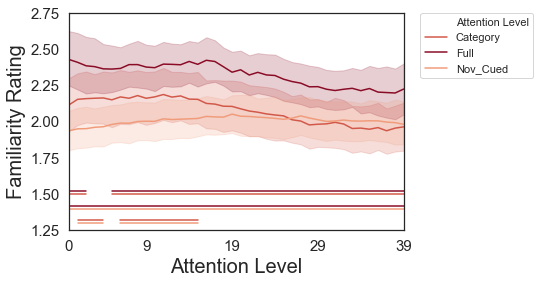

In [26]:
for key,label in zip(plot_data.keys(),['Experiment_1','Experiment_2']):
    
    print(label + ': Sliding Window - Same Category Images - Faces')
    
    data = plot_data[key]
    
    # plot ####################################
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Full', 'Nov_Cued', 'Category'])], # 'Category', # ci=None,
                    palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], "Novel":"black"})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.25, 2.75))
    ax.set(xlim=(0, 39))
    
    #ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Category','Nov_Cued'])#, related=False)    
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Nov_Cued') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[3])
            plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[5])
            
        plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[3])
        plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[5])
        
        
    # ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Category','Full'])
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Category') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.52, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[0])
            plt.axhline( y=1.5, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[3])
        
        
        plt.axhline( y=1.52, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[0])
        plt.axhline( y=1.5, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[3])
        
        
    # ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Nov_Cued','Full'])
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Full') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.42, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[0])
            plt.axhline( y=1.4, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[5])
        
        plt.axhline( y=1.42, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[0])
        plt.axhline( y=1.4, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[5])
        
    # plot settings & save ####################
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    plt.xticks([0, 9, 19, 29, 39])
    
    plt.show()
    

### Images in Cued Location

Experiment_1: Sliding Window - Same Category Images - Faces


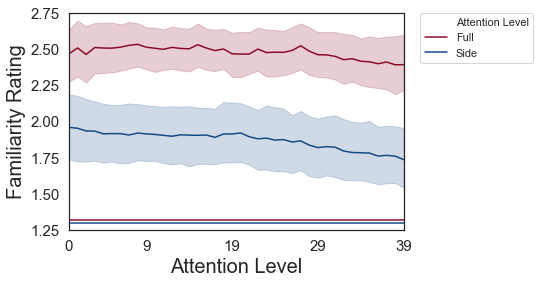

Experiment_2: Sliding Window - Same Category Images - Faces


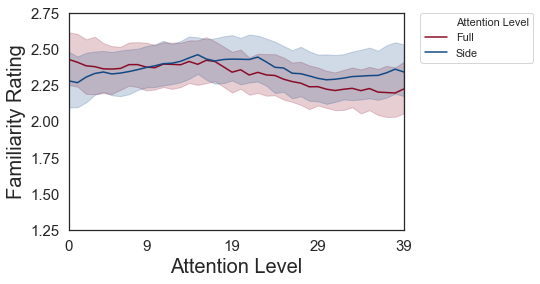

In [30]:
for key,label in zip(plot_data.keys(),['Experiment_1','Experiment_2']):
    
    print(label + ': Sliding Window - Same Category Images - Faces')
    
    data = plot_data[key]
    
    
    # plot ####################################
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Full', 'Side'])], # 'Category', # ci=None,
                    palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], "Novel":"black"})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.25, 2.75))
    ax.set(xlim=(0, 39))
    
    #ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Full','Side'])#, related=False)
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Side') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    
    for x in ranges(index):
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[0])
            plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[19])
            
        plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[0])
        plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[19])
    
        
    # plot settings & save ####################
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    plt.xticks([0, 9, 19, 29, 39])
    
    plt.show()
    

### Images in Uncued Location

Experiment_1: Sliding Window - Same Category Images - Faces


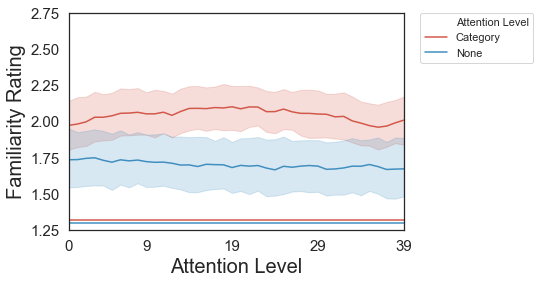

Experiment_2: Sliding Window - Same Category Images - Faces


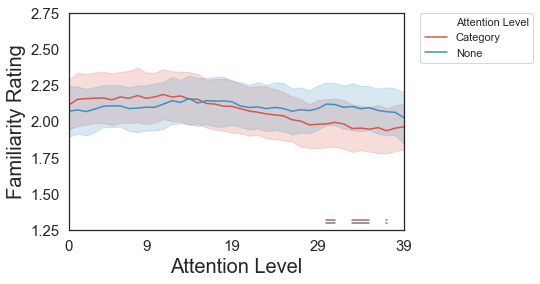

In [33]:
for key,label in zip(plot_data.keys(),['Experiment_1','Experiment_2']):
    
    print(label + ': Sliding Window - Same Category Images - Faces')
    
    data = plot_data[key]
    
    # plot ####################################
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Category', 'None'])], # 'Category', # ci=None,
                    palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], "Novel":"black"})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.25, 2.75))
    ax.set(xlim=(0, 39))
    
    #ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Category','None'])#, related=False)    
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Category') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    
    for x in ranges(index):
               
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[3])
            plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[16])
            
        plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[3])
        plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[16])
    
    
        
    # plot settings & save ####################
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    plt.xticks([0, 9, 19, 29, 39])
    
    plt.show()
    